# Multiple plotting of modules parameters, acquired by the flash test technique, after different treatments

### Introduction
This programm plots the module parameters versus the irradiance for various module treatment. The parameters are acquired using the flash test method.
<br/>
The module parameters, as well as the I/V curves, are stored in .csv files which names obeys the following format:
- UUUdddd_ddddW_Td.csv with U=[A-Z,-,_] and d=[1-9]. We have:
  - UUUdddd_dddd is the module type. The number of U is unlimited  and the  the number of digits d is limited to 50
  - ddddW is the irradiande in W/m^2. The number of digits d cannot be greater than 4.
  - Td is the treatment label. The numer of digit d is equal to 1.
  
These files are stored in the *FLASHTEST_DIR* and all its sub folders. This path is stored in the  configuration file *Pvcharacterization.yaml* and can be iteractivelly changed. 

The structure of the FLASHTEST_DIR must obeys the following structure:
<pre>FLASHTEST_DIR
├── exp_summary.xlsx
├── pv.db
├── BOREALIS
│   ├── LC-BOREALIS-03_0200W_T0.csv
│   ├── LC-BOREALIS-03_0200W_T1.csv
│   └── ...
├── IVcurves
│   ├── EM7621190702200776_1000W_T0.csv
│   ├── EM7621190702200776_1000W_T3.csv
│   └── ...
├── JINERGY
│   ├── JInergy035
│   │   ├── JINERGY3272023326035_0200W_T0.csv
│   │   ├── JINERGY3272023326035_0200W_T1.csv
│   │   └── ....
│   ├── JInergy060
│   │   ├── JINERGY3272023326060_0200W_T0.csv
│   │   ├── JINERGY3272023326060_0200W_T1.csv
│   │   └──...
│   └── JInergy063
│       ├── JINERGY3272023326063_0200W_T0.csv
│       ├── JINERGY3272023326063_0200W_T1.csv
│       └── ...</pre> 
<br>The *WORKING_DIR* contains the sqlite database *pb.db*, a  database containing the two tables PV_descp and exp_values. THE *WORKING_DIR* also contains .xls files generated by PVcharacterization.

<br>A local configuation file *Pvcharacterization.yaml* is store in the folder: linux: ~/.local/share for linux;
macOS: ~/Library/Application Support for macOS; C:/Users/<USER>/AppData/Roaming for windows.



### Description
</br></br>
The program:
1. Interactevelly defines the *data_folder* where *data_folder* must be locate is the users home directory.
2. Recursivelly builds the list of all .csv file located in the folder *data_folder* and its sub-folders.
3. Interactivelly selects the list modules to be analysed and build the dataframe *df_meta* containing all the data necessary to the plotting of the modules parameters
4. Interactivelly defines the list of tuple [(T(i),T(j))], where T(i) stands for the ieme treatment.
5. Interactivelly convert the symbolic items T(i) into the name of the treatment.
6. For *n_params* parameters interactivelly sectected plots the *n_params* the parameters relative variation between two treatments T(k) and T(h):
    
   $$100\frac{{Para{m_i}(Irradiance(n);T(h),module(m)) - Para{m_i}(Irradiance(n);T(k),module(m))}}{{Para{m_i}(Irradiance(n);T(k),module(m))}}$$
   
### Module description
   
The program relies on the package *PVcharacterization_Utils* containig the following modules:
1. PVcharacterization_GUI 
    - input_treatment_labels
    - select_items
    - select_files
    - select_data_dir
2. PVcharacterization_flashtest 
    - assess_path_folders
    - batch_filename_correction
    - build_files_database
    - build_metadata_dataframe
    - build_modules_filenames
    - build_modules_list
    - correct_filename
    - data_dashboard
    - parse_filename
    - pv_flashtest_pca
    - read_flashtest_file
3. config 
    - GLOBAL
    - change_config_pvcharacterization
    - get_config_dir
4. PVcharacterization_image (not used)
    - crop_image
    - py2gwyddion
    - read_electolum_file
5. PVcharacterization_plot
    - construct_x_y
    - init_plot_diff
    - plot_params 
    - plot_params_diff
    - plot_iv_power
6. PVcharacterization_database
    - add_files_to_database
    - sieve_files
    - suppress_duplicate_database
    - sqlite_to_dataframe
    - df2sqlite
7. PVcharacterization_utils
    - plot_time_schedule
    
### How use the package
1. Create/modify the sqlite database
2. Than you can:
   - Perform PCA analysis
   - I/V curves plotting
   - Parameters plotting
   - ...
   
### How modify the module setting
All the global are defined in the PVcharacterization.yaml file located in the package and are accessible from the dict *GLOBAL*.

### Dependancies:

 - numpy
 - matplotlib
 - openpyxl
 - pandas
 - pandasgui
 - plotly (with nbformat>=4.2.0)
 - pyyaml
 - seaborn
 - sceeninfo
 - tkcalendar
 - xlsxwriter
 
<br>Note:
With WIN10 pandasgui requires Visual C++ 2019. You can upgrade Visual C++ using this [site](https://shuchanel.com/resolve-python-pip-error-microsoft-visual-c-14-0-or-greater-is-required/)
    
### Nomenclature:
 - module-type (mod): ex. QCELL-2739, QCELLS901719162417702739
 - parameters (param): ex. Pmax, Voc, Isc, Fill Factor, Rseries (defined in Pvcharacterization.yaml)
 - irradiance (irr): irradiance in W/m^2 (defined in Pvcharacterization.yaml) 
 - treatment (trt): treatment type T0, T1, T2,T2,... (defined in Pvcharacterization.yaml)

In [1]:
''' 
    Creation: 2021.09.13
    Last update: 2021.12.08

    Initialization of the flashtest_dir and of the working_dir
    Database definition/creation

'''

# Standard library imports
import os
from pathlib import Path

# Local imports 
import PVcharacterization_Utils as pv

# Set default values for both the working and the flashtest folders
working_dir = pv.GLOBAL['WORKING_DIR']
flashtest_dir = pv.GLOBAL['FLASHTEST_DIR']


#Defines/creates/modifies the database

if not(os.path.isfile(Path(working_dir) / Path(pv.GLOBAL['DATA_BASE_NAME']))): # If no database detected
    change_flashtest_folder = input(f'No datase detectected. Do you want to use your  default data\
                                    {pv.GLOBAL["FLASHTEST_DIR"]} to build the database (y,n)?')
    if change_flashtest_folder=='y':
        flashtest_dir = pv.assess_path_folders()
        
    change_working_folder = input(f'Your working directory is {pv.GLOBAL["WORKING_DIR"]} do you want to change (y,n)?')
    if change_working_folder=='y':
        working_dir = pv.assess_path_folders()
        
    pv.build_files_database(working_dir,flashtest_dir)
    pv.build_metadata_dataframe(working_dir)
    print(f'builds the database {Path(working_dir) / Path(pv.GLOBAL["DATA_BASE_NAME"])}')
    
else: # A databade already exits
    new_database = input(f'The database {pv.GLOBAL["DATA_BASE_NAME"]} already exits do you want to overwrite it (y,n)?')  
    if new_database == 'y':
        change_flashtest_folder = input(f'Do you want to use your  default data folder:\
                                    {pv.GLOBAL["FLASHTEST_DIR"]} to build the database (y,n)?')
        if change_flashtest_folder=='n':
            flashtest_dir = pv.assess_path_folders()
            
        change_working_folder = input(f'Your working directory is {pv.GLOBAL["WORKING_DIR"]} do you want to change (y,n)?')
    
        if change_working_folder=='y':
            working_dir = pv.assess_path_folders()
            pv.build_files_database(working_dir,flashtest_dir)
        
        pv.build_files_database(working_dir,flashtest_dir)
        print(f'Your new working dir ({working_dir}) and flashtest_dir ({working_dir}) \
              have been saved locally in  the configuration file: {pv.get_config_dir()}\Pvcharacterization.yaml')
        pv.build_metadata_dataframe(working_dir)
    else:
        add_to_database = input(f'Do you want to add file(s) to the existing database (y,n)?')  
        if add_to_database == 'y':
            new_data_folder = pv.assess_path_folders() 
            pv.add_exp_to_database(working_dir,new_data_folder)

pv.change_config_pvcharacterization(flashtest_dir,working_dir)

# Correction of wrong filenames
filename_correct = 'n'
filenames_correct = input('Correction of filenames (y,n)?')
if filenames_correct=='y':
    verb = False
    status = pv.batch_filename_correction(working_dir, verbose=verb)
    print(status)

Number of detected displays: 2
The database pv.db already exits do you want to overwrite it (y,n)?n
Do you want to add file(s) to the existing database (y,n)?n
Correction of filenames (y,n)?n


In [ ]:
''' Creation: 2021.10.17
    Last update: 2021.11.13
    
    df_meta dataframe building from selected files in database DATA_BASE_NAME
    and PCA analysis
    
'''
# Local imports
import PVcharacterization_Utils as pv

list_mod_selected = pv.select_module(working_dir)
list_irradiance = pv.select_irradiance(working_dir,list_mod_selected,mode='select')
df_meta = pv.build_metadata_df_from_db(working_dir,list_mod_selected,list_irradiance)

print(df_meta.describe())
df_meta_pca = pv.pv_flashtest_pca(df_meta,scree_plot = False,interactive_plot=True)

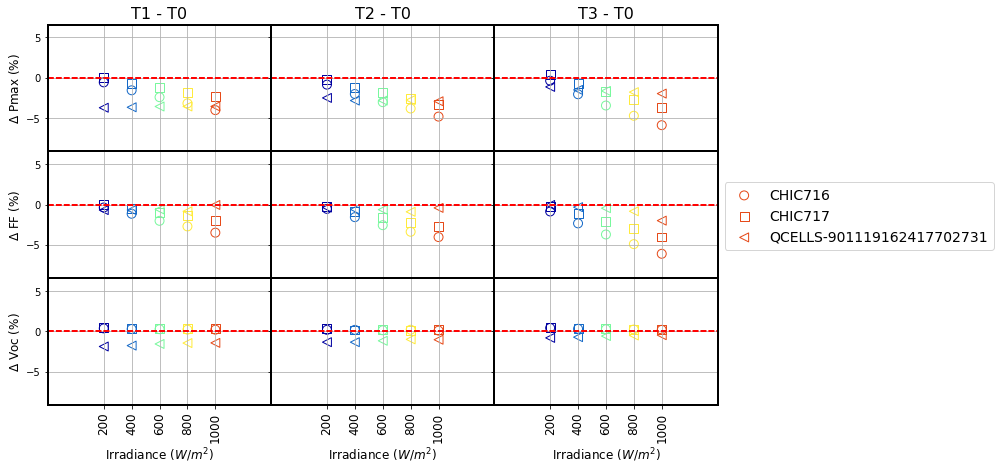

In [2]:
''' Creation: 2021.10.03
    Last update: 2021.11.13
    
    Interactive choice of the treatment differences
    
    ''' 
# Local imports
import PVcharacterization_Utils as pv

plot_params_dict = {'markers': ["o", "s", "<", ">", "p", "1", "2", "3", "4", "+"],
                     'marker_colors': ['#0000A0','#1569C7','#78f89d','#FFEB3B','#E64A19','#d24dff'],
                     'marker_size': 80,
                     'legend_fontsize': 14,
                     'ticks_fontsize': 12,
                     'labels_fontsize': 12,
                     'title_fontsize':16,
                     'fig_width': 12, 
                     'fig_height_unit': 2,
                     'fig_title_height': 1,
                     'bbox_x0': 0.9, 
                     'bbox_y0': 0.5, 
                     'bbox_width': 1, 
                     'bbox_height': 1,
                     'irr_add_nbr':0.5,
                     'y_limit_type': 'extremorum'}

diff = True  # True weplot relative parameters evolution between treaments
             # False we plot parameters evolution
select_irradiance = False
    
list_mod_selected = pv.select_module(working_dir)
if select_irradiance:
    list_irradiance = pv.select_irradiance(working_dir,list_mod_selected,mode='select')
else:
    list_irradiance = pv.select_irradiance(working_dir,list_mod_selected,mode=None)
    
if diff:
    list_diff_treatment = pv.select_diff_treatment(working_dir,list_mod_selected)
    dic_trt_meaning = pv.input_treatment_labels(list_diff_treatment)
    plot_params_dict['y_limit_type'] = 'extremorum'
else:
    list_diff_treatment = []
    plot_params_dict['y_limit_type'] = ''
    
list_params = pv.select_params()
df_meta = pv.build_metadata_df_from_db(working_dir,list_mod_selected,list_irradiance)


pv.plot_params_diff(df_meta,
                    list_diff_treatment,
                    list_params,
                    dic_trt_meaning,
                    long_label=False,
                    plot_params_dict=plot_params_dict,
                    )



In [ ]:
''' Creation: 2021.09.19
    Last update: 2021.11.20
    
    Plotting of I/V curves.
    
    ''' 
# Local imports
import PVcharacterization_Utils as pv

df_files_descp = pv.sqlite_to_dataframe(working_dir,pv.GLOBAL['DATA_BASE_TABLE_FILE'])
list_mod_selected = pv.build_modules_list(df_files_descp)
irr_select = pv.GLOBAL['IRRADIANCE_DEFAULT_LIST']
trt_select = pv.GLOBAL['TREATMENT_DEFAULT_LIST']
pv.plot_iv_curves(irr_select,list_mod_selected,trt_select,working_dir)

In [ ]:
''' Creation: 2021.10.20
    Last update: 2021.11.13
Build a dashboard

'''
# Local imports
import PVcharacterization_Utils as pv

#df_files_descp = pv.sqlite_to_dataframe(working_dir,pv.DATA_BASE_TABLE_FILE)
list_params = ['Pmax']#,'Voc','Isc','Fill Factor','Rseries',]
df_meta_dashboard =  pv.data_dashboard(working_dir,list_params)
df_meta_dashboard

In [ ]:
'''Creation: 2021.11.03
    Last update: 2021.11.04
Plot IV curves
'''
# 3rd party imports
import matplotlib.pyplot as plt

# Local imports
import PVcharacterization_Utils as pv

# Get dataframe describing the experimental files
df_files_descp = pv.sqlite_to_dataframe(working_dir,pv.GLOBAL['DATA_BASE_TABLE_FILE'])   

# Select the module types which names has to be corrected
list_mod_selected = pv.build_modules_list(df_files_descp)
iv_curve = {pv.parse_filename(file): pv.read_flashtest_file(file).IV0 
            for file in pv.build_modules_filenames(working_dir,list_mod_selected)}

colors = {'T0':'r','T3':'k'}
markers = {'EM7621190702200776':'x',
           'EM7621190702200818':'x',
           'SERAPHIM-EM7621190702200646':'v',
           'SERAPHIM-EM7621190702200656':'v'}
fig = plt.figure(figsize=(15,15))
for name,value in iv_curve.items():
    if name.treatment in ['T0','T3'] and name.irradiance==1000:
        plt.scatter(value["Voltage"][::70],
                    value["Current"][::70],
                    s=80,
                    label=f'{name.module_type} {name.treatment}',
                    c=colors[name.treatment],
                    marker=markers[name.module_type],
                    alpha=1)
    
_ = plt.legend()

In [ ]:
'''Creation: 2021.11.03
    Last update: 2021.11.21
Builds a dadaframe with ff,ff_cor,Isc,Isc_cor,100(ff_cor-ff)/ff_cor
Finds the maximum value of 100(ff_cor-ff)/ff_cor
Plots histogram and power I/V curves 
'''
# Standard library imports
from pathlib import Path

#3rd party imports
import matplotlib.pyplot as plt

# Local imports
import PVcharacterization_Utils as pv

list_mod_selected = pv.select_module(working_dir,mode='all')
list_irradiance = pv.select_irradiance(working_dir,list_mod_selected)
df_meta = pv.build_metadata_df_from_db(working_dir,list_mod_selected,list_irradiance)

plt.title(f'{len(df_meta)} experiments')
df_meta['ecart_ff_pc'] = df_meta.apply(lambda x: 100*(x['Fill Factor_corr']-x['Fill Factor'])/x['Fill Factor_corr'],axis=1)
dg = df_meta.query('ecart_ff_pc>0.1')
_ = plt.hist(df_meta['ecart_ff_pc'],bins=30)
plt.xlabel('$100(FF_{cor} - FF)/FF_{cor}$ (%)')
idmax = df_meta['ecart_ff_pc'].idxmax(axis=0)

path_database = working_dir / Path(pv.GLOBAL['DATA_BASE_NAME'])
files = pv.sieve_files([df_meta.loc[idmax,'irradiance']],
                       [df_meta.loc[idmax,'treatment']],
                       [df_meta.loc[idmax,'module_type']],
                       path_database)

pv.plot_iv_power(files[0])

In [ ]:
'''Creation: 2021.11.16
    Last update: 2021.11.18
Plot the mean retative parameters variation of two sets of experiments exp1 and exp2. 
'''


def compute_parameter_relative_diff(df_meta,irradiance, module_type_tag, parameter):
    
    '''Computes:
    100[parameter(TI;irradiance,module_type)-parameter(T0;irradiance,module_type)]/parameter(T0;irradiance,module_type)
    for all TI such that the string module_type_tag is part of the experiment name.
    
    Args:
      df_meta (dataframe): The columns contain the parameter values and the experimental conditions 
          and the row the experiment key.
      irradiance (int): The value of the irradiance used for the experiment.
      module_type_tag (str): A string contained in the module_type.
      parameter (str): The parameter of interest.
      
    Returns
      (namedtuple) a named tuple containing the list of treatments and the list of parameter 
      and a np.array of relative variations.
      
    '''
    
    # Standard library imports
    from collections import namedtuple


    param_diff = namedtuple(
        "param_diff",
        ["treatment", "delta_param"],
    )
    
    df_meta_m = df_meta[(df_meta['module_type'].str.contains(module_type_tag)) &
                        (df_meta['irradiance'] == irradiance)] 
    treatment = df_meta_m['treatment'].tolist()
    param = df_meta_m[parameter].tolist()
    delta_param =np.array( [100*(x-param[0])/param[0] for x in param])
    
    return param_diff(treatment,delta_param)
    

import matplotlib.pyplot as plt
import numpy as np

list_mod_selected = pv.select_module(working_dir,mode='all')
list_irradiance = pv.select_irradiance(working_dir,list_mod_selected)
df_meta = pv.build_metadata_df_from_db(working_dir,list_mod_selected,list_irradiance)

# Data initialization

parameter_list = ['Isc_corr', 'Voc', 'Pmax','Fill Factor_corr']
label = {'exp1': "QCELL_CT", 'exp2': "QCELL_XCT"}

exp1 = ['731', '764']   # QCELL CT
exp2 =  ['749', '754']  # QCELL XCT

dic_exp1 = {'T0':0,'T1':200, 'T2':400, 'T3':600} # treatment: number of cycles for CT
dic_exp2 = {'T0':0,'T1':100, 'T2':200, 'T3':300,'T4':400,'T5':500} # treatment: number of cycles for XCT

irradiance = 1000

for parameter in parameter_list:
    
    # Treat exp1  (CT)
    fig =plt.figure(figsize=(5,5))
    mean_ct = np.array([0]*len(dic_exp1))
    for i, module_name in enumerate(exp1): # recurcive mean
        param_diff = compute_parameter_relative_diff(df_meta,irradiance, module_name, parameter)
        mean_ct = mean_ct*i/(i+1) + param_diff.delta_param/(i+1)
        
    nbr_treatment =[dic_exp1[x] for x in param_diff.treatment]
    plt.plot(nbr_treatment,mean_ct,'--o',label=label['exp1'],markersize=10)
    plt.grid(True)
    
    # Treat exp2 (XCT)
    mean_xct =  np.array([0]*len(dic_exp2))
    for i, module_name in enumerate(exp2): # recurcive mean
        param_diff = compute_parameter_relative_diff(df_meta,irradiance, module_name, parameter)
        mean_xct = mean_xct*i/(i+1) + param_diff.delta_param/(i+1)
        
    nbr_treatment =[dic_exp2[x] for x in param_diff.treatment]
    plt.plot(nbr_treatment,mean_xct,'--v',label=label['exp2'],markersize=10)
    plt.xlabel('Number of cycles')
    plt.ylabel(f'$\Delta$ {parameter} (%)')
    plt.legend()



# New stuff to be discussed

In [ ]:
'''Creation: 2021.11.24
    Last update: 2021.11.25
How querry the database 
'''


def querry_database(working_dir,module_type):
    
    '''
    '''
    
    import sqlite3
    from pathlib import Path
    from string import Template
    
    import PVcharacterization_Utils as pv
    
    #DATA_BASE_NAME = GLOBAL['DATA_BASE_NAME']
    #DATA_BASE_TABLE_FILE = GLOBAL['DATA_BASE_TABLE_FILE']
    DATA_BASE_NAME = pv.GLOBAL['DATA_BASE_NAME']
    DATA_BASE_TABLE_FILE = pv.GLOBAL['DATA_BASE_TABLE_FILE'] 
    
    database_path = Path(working_dir) / Path(DATA_BASE_NAME)
    conn = sqlite3.connect(database_path)

    cursor = conn.cursor()
    
    module_type = f"'{module_type}'" # Beware the simple quote inside the the double quotes

    template = Template('''SELECT irradiance, treatment
                           FROM $table1
                           WHERE module_type=$module_type
                        ''')
    cursor.execute(template.substitute({'table1': DATA_BASE_TABLE_FILE,
                                        'module_type': module_type,}))
    
    result_querry = [(x[0],x[1]) for x in cursor.fetchall()]
    cursor.close()
    conn.close()
    return result_querry

module = "LC-BOREALIS-03"
# Read the list of tuples (irr_i,treatment_j) for experimental setting for a module.
exp_tup = querry_database(working_dir,module) 
irr_list, treatment_list =zip(*exp_tup)
irr_set = set(irr_list)
treatment_set = set(treatment_list)
exp_possible_tup = {(irr,t) for irr in irr_set for t in treatment_set}

exp_tup_sim = [(800, 'T2'), # Redefines exp_tup just for checking
 (800, 'T1'),
 (800, 'T3'),
 (800, 'T0'),
 (200, 'T2'),
 (200, 'T1'),
 (200, 'T0'),
 (1000, 'T2'),
 (1000, 'T1'),
 (1000, 'T3'),
 (1000, 'T0'),
 (400, 'T1'),
 (400, 'T3'),
 (400, 'T0'),
 (600, 'T2'),
 (600, 'T3'),
 (600, 'T0')]

for tup in set(exp_possible_tup - set(exp_tup_sim)):
    print(f'WARNING: the following experimental setting {tup} is missing for the module {module}')

In [ ]:
'''Creation: 2021.11.24
    Last update: 2021.11.25
A snippet for Pati 
'''

#3rd party imports
import matplotlib.pyplot as plt

# Local imports
import PVcharacterization_Utils as pv

irradiance = 1000
parameter = pv.GLOBAL['COL_NAMES'][5] # 1: Pmax, 2:Fill Factor, 3:Voc, 4:Rseries,
                                      # 5: Rshunt, 6: Vpm, 7: Ipm, 8: Isc_corr, 9: Fill Factor_corr
df_meta = pv.build_metadata_df_from_db(working_dir)
module_type = df_meta.loc[df_meta.index[0] ,'module_type']
dg = df_meta.query('irradiance==@irradiance')[[parameter,'treatment']]
_ = plt.plot(dg['treatment'],  dg[parameter],'--o')
_ = plt.ylabel(f'{parameter} ({pv.GLOBAL["PARAM_UNIT_DIC"][parameter]})')
_ = plt.title(module_type)
plt.grid()

In [ ]:
'''Creation: 2021.11.24
    Last update: 2021.11.25
Snippet using dataframe multi indexing 
'''

list_mod_selected = pv.select_module(working_dir,mode='all')
list_irradiance = pv.select_irradiance(working_dir,list_mod_selected)
df_meta = pv.build_metadata_df_from_db(working_dir,list_mod_selected,list_irradiance)
multi = df_meta.set_index(['module_type','irradiance', ])
g = multi.loc[('SERAPHIM-EM7621190702200646', 1000),:]
_ = plt.plot(g['treatment'],g['Fill Factor_corr'],'--o' )

In [ ]:
#3rd party imports
import matplotlib.pyplot as plt

# Local imports
import PVcharacterization_Utils as pv

df_meta = pv.build_metadata_df_from_db(working_dir)
g = df_meta.pivot(values= ['Pmax','irradiance'],index=['module_type','treatment' ],
              columns=['irradiance',]) 
x = g.loc[g.index[0][0],g.index[0][1]] ['irradiance'].to_numpy()
y = g.loc[g.index[0][0],g.index[0][1]] ['Pmax'].to_numpy()
_ = plt.scatter(x,y)
_ = plt.title(f'module:{g.index[0][0]}, treatment: {g.index[0][1]}')
_  = plt.xlabel('irradiance(W/cm^2)')
_ = plt.ylabel('Power (W)')

## Tools to improve data vizualization and exploration

In [ ]:
'''Creation: 2021.11.24
    Last update: 2021.11.25
How improve dataframe visualization 
'''
list_mod_selected = pv.select_module(working_dir,mode='all')
list_irradiance = pv.select_irradiance(working_dir,list_mod_selected)
df_meta = pv.build_metadata_df_from_db(working_dir,list_mod_selected,list_irradiance)
df_meta.drop(['exp_id','Title','Fill Factor','Isc'],axis=1,inplace=True)
df_meta.style.bar(
    subset=["Pmax", "Fill Factor_corr"], color="#205ff2"
).format({'Pmax':'{:.2f}',
          'Voc':'{:.2f}',
          'Rseries':'{:.2f}',
          'Rshunt':'{:.2f}',
          'Vpm':'{:.2f}',
          'Ipm':'{:.2f}',
          'Isc_corr':'{:.2f}',
          'Fill Factor_corr':'{:.2f}',}).highlight_min(['Pmax','Fill Factor_corr'])

In [ ]:
'''Creation: 2021.11.24
    Last update: 2021.12.01
How improve dataframe exploration
'''

from pandasgui import show
list_mod_selected = pv.select_module(working_dir,mode='all')
list_irradiance = pv.select_irradiance(working_dir,list_mod_selected)
df_meta = pv.build_metadata_df_from_db(working_dir,list_mod_selected,list_irradiance)
gui = show(df_meta)

In [ ]:
import pprint as pp
pp.pprint(pv.GLOBAL, depth=3, indent=4)

In [ ]:
'''Creation: 2021.12.02
    Last update: 2021.12.08
    need to install tkcalendar (pip install tkcalendar)
Plot a time schedule
'''
# Standard librariy imports
import os.path
from pathlib import Path

# Local imports 
import PVcharacterization_Utils as pv    
    
path_suivi_module = pv.GLOBAL["FLASHTEST_DIR"] / Path('Copie de Suivi des modules en enceinte.xlsx')
if not os.path.exists(path_suivi_module):
    print(f"The file {path_suivi_module} doesn't exit. Please select a valid path")
    selected_files = pv.select_files()
    path_suivi_module = selected_files[0]
    
path_time_schedule = pv.GLOBAL["WORKING_DIR"] / Path('time_schedule.html')

dep_time = pv.get_date()

pv.plot_time_schedule(path_suivi_module, path_time_schedule, dep_time)


In [ ]:
'''Creation: 2021.12.04
    Last update: 2021.12.04
Demonstration of database constructruction and querying.
'''

# Standard librariy imports
import os
from pathlib import Path

# Local imports 
import PVcharacterization_Utils as pv  

# Reads and cleans the .xlsx file
path_suivi_module = pv.GLOBAL["FLASHTEST_DIR"] / Path('Copie de Suivi des modules en enceinte.xlsx')
if not os.path.exists(path_suivi_module):
    print(f"The file {path_suivi_module} doesn't exit. Please select a valid path")
    selected_files = pv.select_files()
    path_suivi_module = selected_files[0]
    
pv.build_timeline_db(path_suivi_module)



In [ ]:
# Standard librariy imports
from pathlib import Path
import sqlite3

# 3rd party imports
import pandas as pd

# Query the database
db_name = 'module_timeline.db' # Database file name
    
path_suivi_module = pv.GLOBAL["FLASHTEST_DIR"] / Path('Copie de Suivi des modules en enceinte.xlsx')
db_path =  pv.GLOBAL["WORKING_DIR"] / Path(db_name)
conn = sqlite3.connect(db_path)
cur = conn.cursor()
cur.execute('''  
            SELECT *,COUNT(*) how_many
            FROM data
            WHERE (DATE_ENTREE >{})
            GROUP BY PROJET
          '''.format("'2020-10-29'"))

dict_query = {i:row for i, row in enumerate(cur.fetchall())}


dg = pd.DataFrame.from_dict(dict_query).T
#dg.columns = df.columns
    
cur.close()
conn.close() 

In [ ]:
# 3rd party imports
import yaml

local_config_path = r'C:\tmp\pv.yaml'
with open(local_config_path) as file:
    global_ = yaml.safe_load(file)

In [ ]:
v = []
bool(v)